In [10]:
#source https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [11]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import create_simdata
import functions
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

For XGBoost model we need to reformulate the problem as a supervised learning. This can be done by using the lagged values as input features **X** and using the actual timeseries values as output **y**.

In [12]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, lag = 1):
    df = pd.DataFrame(data)
    #theoretically can have several lagged values
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis = 1)
    df.columns = ["t", "t-1"]
    df.fillna(0, inplace = True)
    return df

Because we are in forecasting mode, we cannot shuffle the data for evaluation. Instead we are going to use *walk-forward validation*.<br><br>
In walk-forward validation, the dataset is first split into train and test sets using a cut-point. If we are interested in one time-step forecast, then we can evaluate the model by training on the training sset and predicting first step in the test dataset. Then add the real observation from test set to the training, refit the model, predict the second step and so on...

In [13]:
# walk-forward validation for univariate data
def walk_forward_validation(data):
    predictions = []
    # 70%/30% train/test split
    n = len(data)
    train, test = data[:int(n*0.7)], data[int(n*0.7):]
    history = train.copy()
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        #target y is the first column in the dataset
        test_X, test_y = test.iloc[i, 1:], test.iloc[i, 0]
        #test_X is a series, but our model was trained on dataframe
        test_X = test_X.to_frame().T.reset_index(drop = True)
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, test_X)
        predictions.append(yhat)
        #appending test observation to training requires transforming it to dataframe
        new_data = test.iloc[i].to_frame().T.reset_index(drop = True)
        # add actual observation to training data for the next loop
        history = history.append(new_data, ignore_index = True)
    # estimate prediction error
    error = mean_absolute_error(test.iloc[:, 0], predictions)
    return error, test.iloc[:, 0].reset_index(drop = True), predictions

The *xgboost_forecast()* function takes training dataset and test input row as input, fitting the model and making one-step prediction.

In [14]:
def xgboost_forecast(train, test_X):
    train_X, train_y = train.iloc[:,1:], train.iloc[:,0]
    #tried out n_estimators [x for x in range(100,2000,100)] -> 100 was the best according to MAE
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, random_state = 40)
    model.fit(train_X, train_y)
    yhat = model.predict(test_X)
    return yhat[0]

Testing on artificial datasets using 5 lagged features.<br>
Figures on the left - without concept included as features.<br>
Figures on the right - witth concept included as features.

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


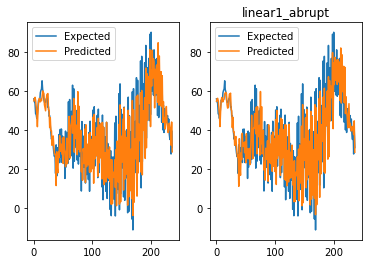

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


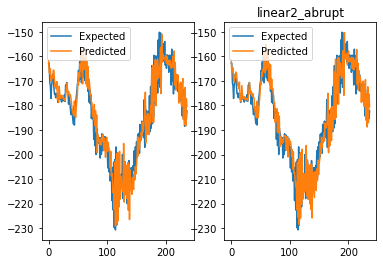

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


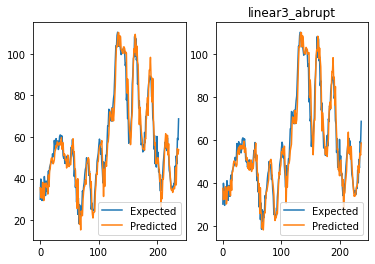

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


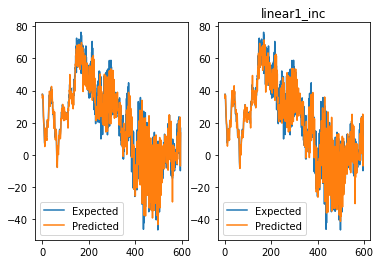

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


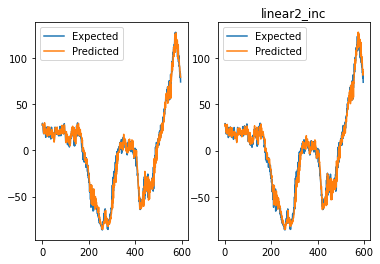

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


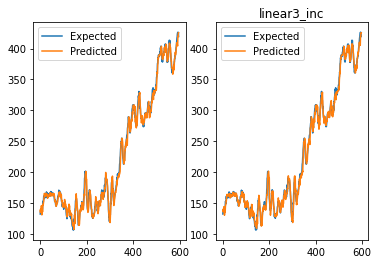

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


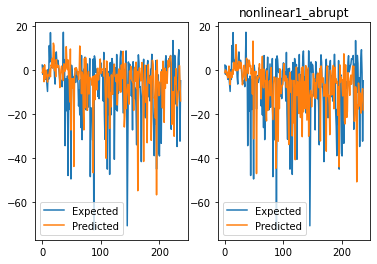

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


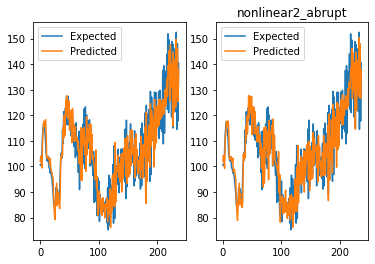

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


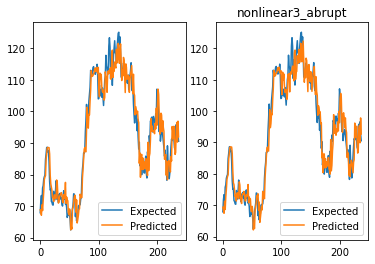

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


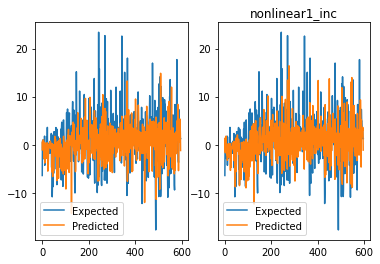

/home/akuma/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


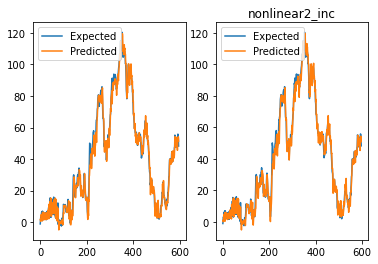

In [15]:
list_of_functions = [("linear1_abrupt",create_simdata.linear1_abrupt),
             ("linear2_abrupt",create_simdata.linear2_abrupt),
             ("linear3_abrupt",create_simdata.linear3_abrupt),
             ("linear1_inc", create_simdata.linear1_inc),
             ("linear2_inc", create_simdata.linear2_inc),
             ("linear3_inc", create_simdata.linear3_inc),
             ("nonlinear1_abrupt",create_simdata.nonlinear1_abrupt),
             ("nonlinear2_abrupt",create_simdata.nonlinear2_abrupt),
             ("nonlinear3_abrupt",create_simdata.nonlinear3_abrupt),
             ("nonlinear1_inc", create_simdata.nonlinear1_inc),
             ("nonlinear2_inc", create_simdata.nonlinear2_inc),
                     #some problem when creating data for this function
#              ("nonlinear3_inc", create_simdata.nonlinear3_inc)
                    ]
mae_with_concept = {}
mae_without_concept = {}

for name, fun in list_of_functions:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    data = functions.ada_preprocessing(pd.Series(fun()), delay_correction = 3)
    one_hot_encoded = pd.get_dummies(data["concept"])
    data.drop("concept", axis = 1, inplace = True)
    #fitting and plotting without concept
    mae_total, y, yhat = walk_forward_validation(data.drop("transition", axis = 1, inplace = False))
    mae_without_concept[name] = mae_total
    ax1.plot(y, label = "Expected")
    ax1.plot(yhat, label = "Predicted")
    ax1.legend()
    #fitting and plotting with concept
    data = pd.concat([data, one_hot_encoded], axis = 1, sort = False)
    data["transition"] = data["transition"].astype(int)
    mae_total, y, yhat = walk_forward_validation(data)
    mae_with_concept[name] = mae_total
    ax2.plot(y, label = "Expected")
    ax2.plot(yhat, label = "Predicted")
    ax2.legend()
    plt.title(name)
    plt.show()

In [19]:
print("Improvement in MAE after including concept indicators")
for name, _ in list_of_functions:
    print("{}: {:.4f}".format(name, mae_without_concept[name]-mae_with_concept[name]))

Improvement in MAE after including concept indicators
linear1_abrupt: -0.2206
linear2_abrupt: -0.0414
linear3_abrupt: 0.2287
linear1_inc: 0.0933
linear2_inc: -0.0413
linear3_inc: 0.0854
nonlinear1_abrupt: -0.2262
nonlinear2_abrupt: -0.0080
nonlinear3_abrupt: 0.0352
nonlinear1_inc: 0.3878
nonlinear2_inc: 0.0093


In [20]:
avg_without = np.mean(list(mae_without_concept.values()))
avg_with = np.mean(list(mae_with_concept.values()))
print("Average MAE without concept indicators {:.3f}".format(avg_without))
print("Average MAE with concept indicators {:.3f}".format(avg_with))

Average MAE without concept indicators 5.139
Average MAE with concept indicators 5.112


It doesn't seem like including the concept indication improves the error significantly.